# Getting started guide to GraphRAG using the GraphRAG Toolkit

## Prerequisites

Prior to using this Notebook, you will need to have setup a new [OpenSearch Serverless Collection](https://console.aws.amazon.com/aos/home#opensearch/collections/create-collection) in your current region using the following configuration:

- Collection Name: `graphrag`
- Collection Type: `Vector search`
- Security: `Easy create`

In addition, you will also need to have created a [Neptune Database cluster](https://console.aws.amazon.com/neptune/home?database-create:). For simplicity, you can create a Serverless cluster with the following configuration:

- Type: `Serverless`
- Engine Version: `1.4.5.1.R1` (or the latest)
- Templates: `Development and testing`
- Cluster Storage: `Neptune Standard`
- Capacity section: `8`(min), `128`(max)
- VPC: `Default`

Finally, create an [S3 bucket](https://console.aws.amazon.com/s3/bucket/create?bucketType=general) in the same region as your OpenSearch Serverless collection and Neptune Database.

### Setting up security

The role that is associated with this Notebook also needs to be able to access your OpenSearch Serverless collection and Neptune cluster, invoke Bedrock Models, and write to S3 as part of the batch process.

To set this up, go to the [SageMaker notebooks console](https://console.aws.amazon.com/sagemaker/home#/notebook-instances) and click the link for this notebook. In the **Permissions and encryption** section, click the link for the **IAM role ARN**. From the IAM console page, add the following permissions:

1. AmazonBedrockFullAccess
2. AmazonS3FullAccess

Copy the **IAM role ARN** as shown below. This will be needed allow access to the OpenSearch Serverless collection

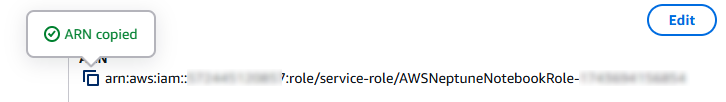


### Adding the IAM role to the OpenSearch Serverless collection

Once the `graphrag` OpenSearch Serverless collection has been created, go to the [Serverless Collections console](https://console.aws.amazon.com/aos/home?#opensearch/collections) and click the link for the collection. In the **Data access** section, click the link of the policy found under the **Associated policy**. Follow the steps below to add the notebook IAM role to the security policy:

1. On the Data access control page for the security policy, click the **Edit** button
2. On the new page, scroll down to the **Select principals** section.
3. Click the **Add principals** button, and select **IAM users and roles**
4. In the new window, paste the notebook IAM role into the search box. The list will filter to only display the notebook role. 
5. Select the role, and click **Save** to close the window.

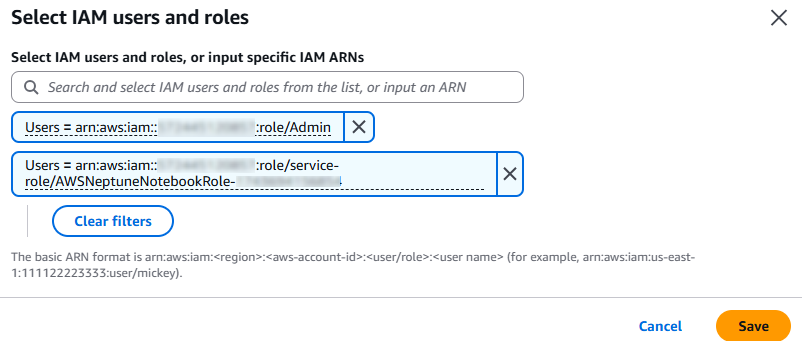

6. Scroll to the bottom of the security policy window and click **Save**




## Install the GraphRAG toolkit

At the time of writing, the latest version of the GraphRAG toolkit was **3.8.3**, which this code has been tested on. 

For more recent updates, please check the [releases page in GitHub](https://github.com/awslabs/graphrag-toolkit/releases).

In [1]:
!pip install https://github.com/awslabs/graphrag-toolkit/archive/refs/tags/v3.8.3.zip#subdirectory=lexical-graph -q

In [48]:
!pip install torch sentence_transformers -q

In [2]:
!pip install beautifulsoup4 -q

## Import libraries and classes

In [3]:
import time
import os
import boto3
import requests

from bs4 import BeautifulSoup

from graphrag_toolkit.lexical_graph import set_logging_config, GraphRAGConfig, IndexingConfig, ExtractionConfig, LexicalGraphIndex
from graphrag_toolkit.lexical_graph.storage import GraphStoreFactory
from graphrag_toolkit.lexical_graph.storage import VectorStoreFactory
from graphrag_toolkit.lexical_graph.storage.graph import NonRedactedGraphQueryLogFormatting
from graphrag_toolkit.lexical_graph.indexing import sink
from graphrag_toolkit.lexical_graph.indexing.constants import PROPOSITIONS_KEY, DEFAULT_ENTITY_CLASSIFICATIONS
from graphrag_toolkit.lexical_graph.indexing.extract import LLMPropositionExtractor
from graphrag_toolkit.lexical_graph.indexing.extract import TopicExtractor, BatchConfig, InferClassificationsConfig, OnExistingClassifications
from graphrag_toolkit.lexical_graph.indexing.extract import GraphScopedValueStore
from graphrag_toolkit.lexical_graph.indexing.extract import ScopedValueProvider, DEFAULT_SCOPE
from graphrag_toolkit.lexical_graph.indexing.extract import ExtractionPipeline
from graphrag_toolkit.lexical_graph.indexing.build import Checkpoint
from graphrag_toolkit.lexical_graph.indexing.build import BuildPipeline
from graphrag_toolkit.lexical_graph.indexing.build import VectorIndexing
from graphrag_toolkit.lexical_graph.indexing.build import GraphConstruction

from llama_index.core.node_parser import SentenceSplitter

from llama_index.core import Document

import nest_asyncio
nest_asyncio.apply()

### Set logging levels

In [4]:
set_logging_config('INFO', ['graphrag_toolkit.indexing.extract', 'graphrag_toolkit.indexing.build'])

### Set the graph endpoint

In [ ]:
#CHECKPOINT is used to 'bookmark' the currently generated embeddings so that the toolkit doesn't start from the 
#beginning if an error occurs
CHECKPOINT = "graphrag-web-ingest"

#GRAPH_ENDPOINT is the primary/writer endpoint of your Neptune cluster
GRAPH_ENDPOINT = "<UPDATE WITH THE NEPTUNE WRITER ENDPOINT>"
#VECTOR_ENDPOINT is the OpenSearch endpoint of your OpenSearch Serverless collection
VECTOR_ENDPOINT = "<UPDATE WITH THE SERVERLESS COLLECTION ENDPOINT>"

#GRAPH_STORE is formatted specifically for use with the GraphRAG toolkit
GRAPH_STORE = f"neptune-db://{GRAPH_ENDPOINT}"
#VECTOR_STORE is formatted specifically for use with the GraphRAG toolkit
VECTOR_STORE = f"aoss://{VECTOR_ENDPOINT}"

#BATCH_** variables are used to perform batch inference. 
#For more information on batch inference, see (https://github.com/awslabs/graphrag-toolkit/blob/main/docs/lexical-graph/batch-extraction.md)
BATCH_EXTRACTION_REGION = os.environ['REGION'] #must be in the same region as your S3 bucket
BATCH_EXTRACTION_BUCKET_NAME = os.environ["BATCH_EXTRACTION_BUCKET_NAME"]
BATCH_EXTRACTION_KEY_PREFIX = os.environ["BATCH_EXTRACTION_KEY_PREFIX"]
#For more information creating the custom service role for batch inference, see (https://github.com/awslabs/graphrag-toolkit/blob/main/docs/lexical-graph/batch-extraction.md#setup)
BATCH_EXTRACTION_ROLE_ARN = os.environ["BATCH_EXTRACTION_ROLE_ARN"]

In [ ]:
%graph_notebook_host {GRAPH_ENDPOINT}

## Read the data from the webpages

In this example, we're using the `boto3` AWS SDK client along to read files in our S3 bucket and store the contents in a list of LlamaIndex `Documents`. In order to preserve some information about the source, we're storing the `key` of the file in the `metadata` property of the Document. This will also be stored in our graph.

In [ ]:
urls = [
    "https://docs.aws.amazon.com/neptune/latest/userguide/intro.html",
    "https://docs.aws.amazon.com/neptune/latest/userguide/graph-get-started.html",
    "https://docs.aws.amazon.com/neptune/latest/userguide/neptune-setup.html",
    "https://docs.aws.amazon.com/neptune-analytics/latest/userguide/what-is-neptune-analytics.html#neptune-analytics-vs-neptune-database"
]

docs = []

print("Reading Web pages ...")
start = time.perf_counter()

for u in urls:
    c = requests.get(u)
    html = c.text
    soup = BeautifulSoup(html,'html.parser')

    docs.append(Document(text=str(soup.body),metadata={'webpage':u}))
    

end = time.perf_counter()
time_obj = time.gmtime(float(end - start))

print(f"Web pages read. {len(docs)} nodes identified. Time taken {time.strftime('%H hours, %M minutes and %S seconds',time_obj)}")

## GraphRAG Toolkit Setup

First we need to define our checkpoint. This is used to backtrack to a last successful point in the extraction process, so that if an error occurs, we don't need to reprocess all the files we've already successfully ingested.

In [31]:
checkpoint = Checkpoint(CHECKPOINT, enabled=True)

### Specify the graph as our `GraphStoreFactory`
For debugging purposes, we're also specifying the log format for the graph queries as the `NonRedactedGraphQueryLogFormatting` class. This displays the full openCypher query, along with additional context in the logged output. By default, the toolkit uses the `RedactedGraphQueryLogFormatting` class which sets the query to `**REDACTED**` to ensure PII is not displayed in debug logs.

In [32]:
graph_store = GraphStoreFactory.for_graph_store(GRAPH_STORE,
                log_formatting = NonRedactedGraphQueryLogFormatting())

### Specify the graph as our `VectorStoreFactory`

In [33]:
vector_store = VectorStoreFactory.for_vector_store(VECTOR_STORE)

### Set-up Chunking Strategy

In [34]:
splitter = SentenceSplitter(
    chunk_size=256,
    chunk_overlap=20
)

### Batch Configuration

The GraphRAG toolkit can use Bedrock batch inference in the extraction stage of the indexing process to improve the speed of ingesting multiple documents. For more information, see the [Batch Extraction](https://github.com/awslabs/graphrag-toolkit/blob/main/docs/lexical-graph/batch-extraction.md) page in the GraphRAG Toolkit repository on GitHub.

Using batch inference causes the toolkit to store extracts of the documents into the S3 bucket/key defined by the `BATCH_EXTRACTION_BUCKET_NAME` and `BATCH_EXTRACTION_KEY_PREFIX` variables. These are then passed as input parameters to the batch inference jobs. Once the jobs have been submitted, they will be added to the submission queue and be processed. Depending on the region and model availability, this could take anywhere between a few minutes and several hours.

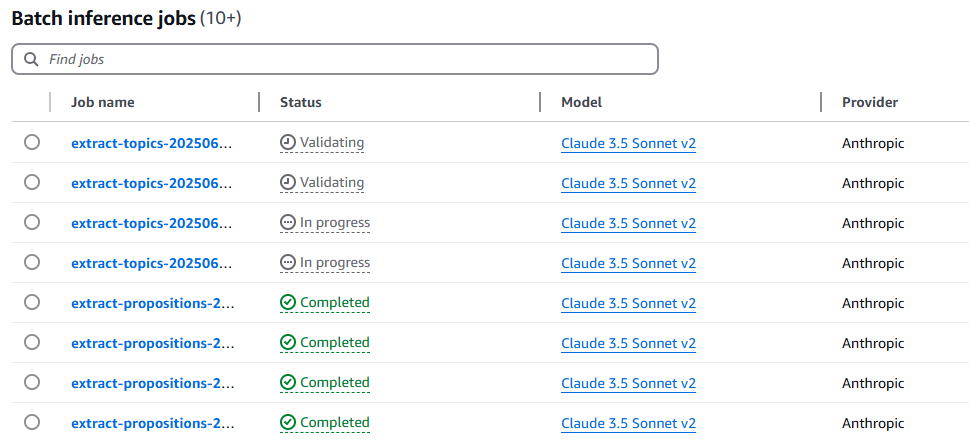

### Setting the global configuration

In [35]:
GraphRAGConfig.extraction_batch_size = 5000 #edit the batch size to pass more chunks to the LLM
GraphRAGConfig.extraction_num_workers = 4

GraphRAGConfig.include_domain_labels = True #important!

GraphRAGConfig.build_num_workers = 4
GraphRAGConfig.build_batch_write_size = 10

GraphRAGConfig.extraction_llm = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
GraphRAGConfig.response_llm = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"


In [68]:
batch_config = BatchConfig(
    region=BATCH_EXTRACTION_REGION,
    bucket_name=BATCH_EXTRACTION_BUCKET_NAME,
    key_prefix=BATCH_EXTRACTION_KEY_PREFIX,
    role_arn=BATCH_EXTRACTION_ROLE_ARN
)

In [36]:
indexing_config = IndexingConfig(
    batch_config=batch_config,
    chunking=[splitter],
    extraction=ExtractionConfig(
        enable_proposition_extraction=True,
        preferred_entity_classifications=DEFAULT_ENTITY_CLASSIFICATIONS
    )
)

#### Initiate the graph store and vector index

In [37]:
graph_index = LexicalGraphIndex(
    graph_store, 
    vector_store,
    indexing_config=indexing_config
)

In [ ]:
print(f"Extracting and building the graph store and vector index from {len(docs)} nodes ...")
start = time.perf_counter()

graph_index.extract_and_build(docs,checkpoint=checkpoint,show_progress=True)

end = time.perf_counter()
time_obj = time.gmtime(float(end - start))

print(f"Extraction and build complete. Time taken {time.strftime('%H hours, %M minutes and %S seconds',time_obj)}")

## Querying the Graph

The following image depicts the data model that the GraphRAG toolkit creates.

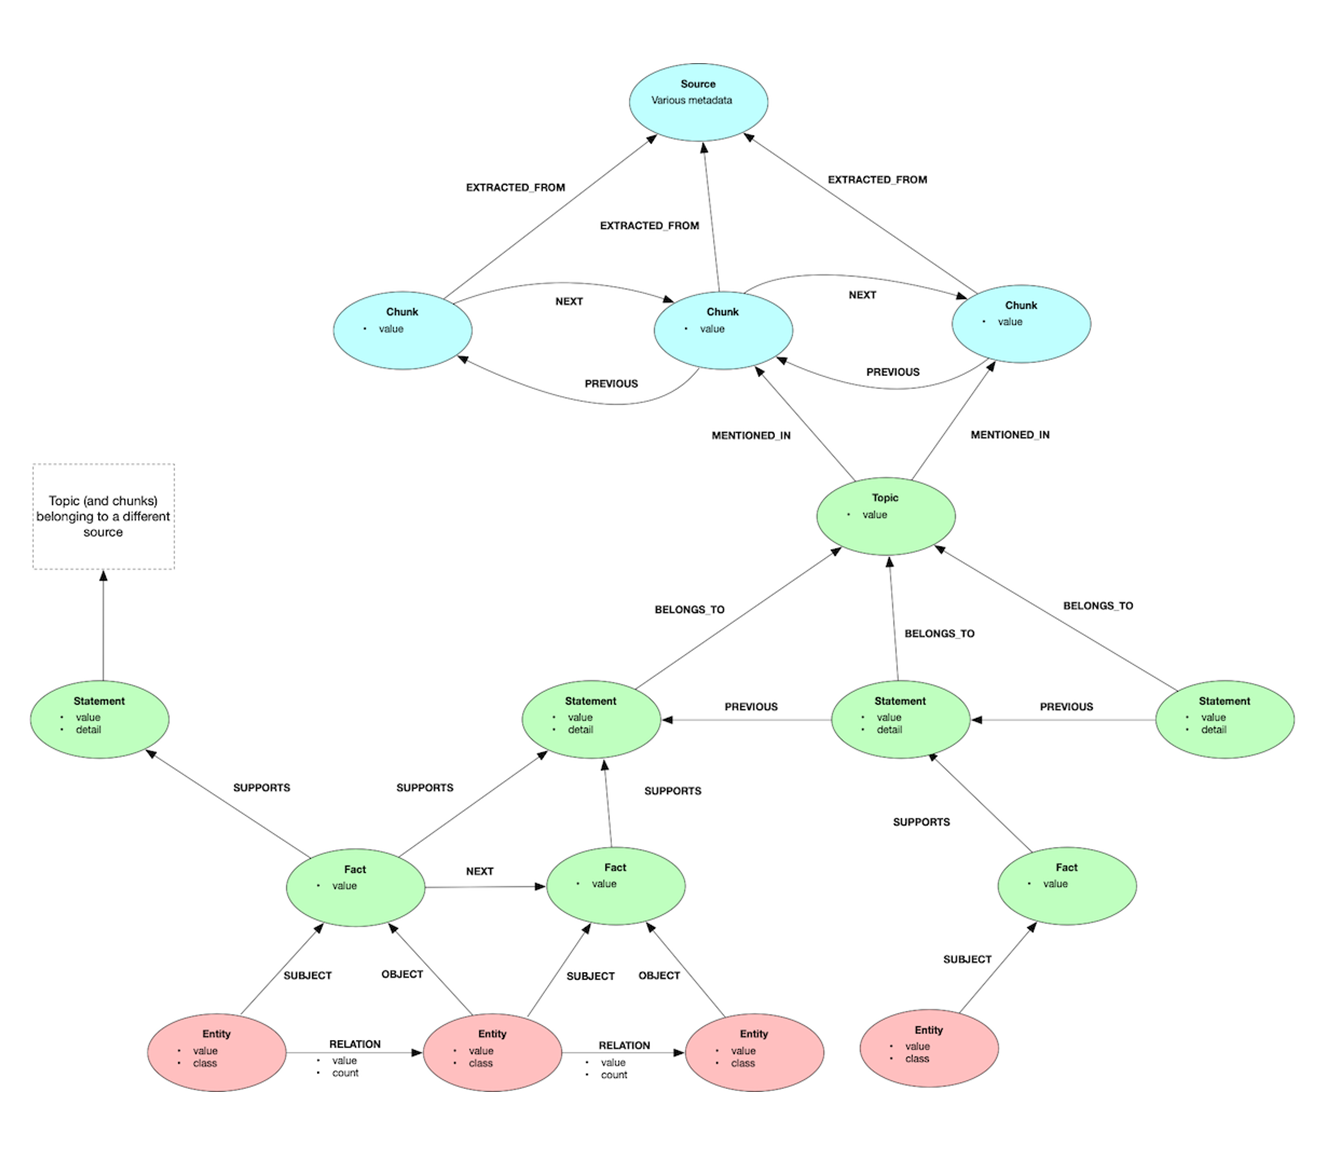

In [40]:
from graphrag_toolkit.lexical_graph import LexicalGraphQueryEngine
from graphrag_toolkit.lexical_graph.retrieval.retrievers import ChunkBasedSearch
from graphrag_toolkit.lexical_graph.retrieval.retrievers import RerankingBeamGraphSearch, StatementCosineSimilaritySearch, KeywordRankingSearch, SemanticBeamGraphSearch
from graphrag_toolkit.lexical_graph.retrieval.post_processors import SentenceReranker, StatementDiversityPostProcessor, StatementEnhancementPostProcessor

The GraphRAG toolkit provides two mechanisms for searching the graph; traversal-based searches and semantic guided searches. Let's create a simple function that can perform both, in order to reduce the amount of code we write later.

In [41]:
def perform_search(your_question, search_method="lexical", search_retrievers=[]):    
    query_engine = None
    if search_method == "lexical":
        query_engine = LexicalGraphQueryEngine.for_traversal_based_search(
            graph_store, 
            vector_store
        )
    elif search_method == "semantic":
        query_engine = LexicalGraphQueryEngine.for_semantic_guided_search(
            graph_store, 
            vector_store,
            streaming=True,
            retrievers=search_retrievers
        )
        
    return query_engine.query(your_question)

In [42]:
search_question = f"""
   What are the differences between Neptune Database and Neptune Analytics?
"""

### Traversal-based Search

In [ ]:
traversal_response = perform_search(search_question)
print(traversal_response.response)

The above will produce a responses, similar to the following:

```
Based on the search results, I can identify the following differences between Neptune Database and Neptune Analytics:

Neptune Database:
- Is a graph database service within the AWS ecosystem [Source: https://docs.aws.amazon.com/neptune/latest/userguide/graph-get-started.html]
- Supports multiple query languages including Gremlin, openCypher/Cypher, and SPARQL [Source: https://docs.aws.amazon.com/neptune/latest/userguide/neptune-setup.html]
- Often referred to as "Neptune Graph database" [Source: https://docs.aws.amazon.com/neptune/latest/userguide/neptune-setup.html]

Neptune Analytics:
- Is an analytics database engine that complements Neptune database [Source: https://docs.aws.amazon.com/neptune/latest/userguide/intro.html]
- Specifically designed for low-latency analytic queries [Source: https://docs.aws.amazon.com/neptune/latest/userguide/intro.html]
- Can quickly analyze large amounts of graph data in memory [Source: https://docs.aws.amazon.com/neptune/latest/userguide/intro.html]
- Uses popular graph analytic algorithms [Source: https://docs.aws.amazon.com/neptune/latest/userguide/intro.html]
- Helps find trends in graph data [Source: https://docs.aws.amazon.com/neptune/latest/userguide/intro.html]
- Serves as a solution for quickly analyzing existing graph databases [Source: https://docs.aws.amazon.com/neptune/latest/userguide/intro.html]

The relationship between the two is complementary, with Neptune Analytics enhancing the capabilities of the core Neptune database service.
```

In [ ]:
for n in traversal_response.source_nodes:
    print(n.text)

The above code retrieves a list of all the sources, topics and statements that were extracted and used as part of the summarised response. Each `source_node` contains the connected `source` node, i.e. the URL of the web page, the relevant associated `topic` node, and the `statement` nodes that were identified as being relevant to the question being asked. The output will be similar to the following:

```
{
  "source": "https://docs.aws.amazon.com/neptune/latest/userguide/graph-get-started.html",
  "topic": "Amazon Neptune Database Service",
  "statements": [
    "Graph notebooks provide deeper exploration of Neptune.",
    "Users familiar with graphs can jump ahead to \"Using Neptune with graph notebooks\".",
    "Neptune supports Gremlin query language.",
    "Neptune supports openCypher query language.",
    "Neptune supports SPARQL query language.",
    "Neptune Graph database is offered by Amazon.",
    "Amazon Neptune is a Graph database.",
    "Amazon Neptune is a graph database service.",
    "Neptune is a graph database.",
    "Neptune supports Cypher query language."
  ]
}
```

In [ ]:
for n in traversal_response.source_nodes:
    print(n.metadata['source'])

### Semantic Guided Search

In [ ]:
from graphrag_toolkit.lexical_graph.retrieval.post_processors import SentenceReranker

cosine_retriever = StatementCosineSimilaritySearch(
    vector_store=vector_store,
    graph_store=graph_store,
    top_k=50
)

keyword_retriever = KeywordRankingSearch(
    vector_store=vector_store,
    graph_store=graph_store,
    max_keywords=10
)

reranker = SentenceReranker(
    batch_size=128
)

beam_retriever = RerankingBeamGraphSearch(
    vector_store=vector_store,
    graph_store=graph_store,
    reranker=reranker,
    initial_retrievers=[cosine_retriever, keyword_retriever],
    max_depth=8,
    beam_width=100
)

Running a `semantic` traversal and providing additional post processors that re-rank the retrieved nodes based on relevancy can also help us gain a more accurate response to our question. The following provides a response similar to the below:

```
Neptune Database:
- A fully managed graph database service [source_1, source_2, source_3]
- Designed for processing graphs of highly connected data [source_1]
- Stores data in a cluster volume [source_1]
- Requires DB clusters and instances for setup [source_2]
- Supports multiple query languages including Gremlin, openCypher, and SPARQL [source_1]
- Handles operational tasks like writing, loading, and modifying graph database contents [source_1]
- Optimized for storing and querying relationships between data items [source_3]
- Can query relationships with milliseconds latency [source_3]

Neptune Analytics:
- An analytics database engine [source_1]
- Complements the Neptune database [source_1]
- Designed for quickly analyzing existing graph databases or graph datasets stored in data lakes [source_1]
- Uses low-latency analytic queries [source_1]
- Can quickly analyze large amounts of graph data in memory [source_1]
- Helps find trends and get insights from graph data [source_1]
- Uses popular graph analytic algorithms [source_1]

The key distinction is that Neptune Database is for storing and querying graph data in operational scenarios, while Neptune Analytics is specifically designed for analyzing graph data quickly to derive insights and trends.
```

Notice how the final paragraph provides a **key differences** (as per the question), rather than just explaining how the two database engines work with each other.

In [ ]:
response = perform_search(search_question,"semantic",[cosine_retriever,keyword_retriever,beam_retriever])
print(response.response)

Similar to the `traversal` based approach, we can retrieve the `sources` and `statements` associated with a specific response. The format is slightly different, but still provides us with a view of the information used to provide the final summarisation.

```
<source_1>
<source_1_metadata>
	<webpage>https://docs.aws.amazon.com/neptune/latest/userguide/intro.html</webpage>
</source_1_metadata>
<statement_1.1>Neptune Analytics is an analytics database engine.</statement_1.1>
<statement_1.2>Neptune Analytics is a solution for quickly analyzing existing graph databases.</statement_1.2>
<statement_1.3>Neptune Analytics is a solution for quickly analyzing graph datasets stored in a data lake.</statement_1.3>

... truncated for brevity

<statement_1.72>Neptune powers network security use cases.</statement_1.72>
<statement_1.73>Each Neptune DB cluster can have up to 15 Neptune Replicas in addition to the primary DB instance.</statement_1.73>
<statement_1.74>The document has a PDF version available at "/pdfs/neptune/latest/userguide/neptune-ug.pdf#intro".</statement_1.74>
<statement_1.75>Neptune replica connects to the same storage volume as the primary DB instance.</statement_1.75>
</source_1>
```

In [ ]:
for n in response.source_nodes:
    print(n.text)

## Visualisation

In [ ]:
from graphrag_toolkit.lexical_graph.retrieval.model import SearchResult

def get_query_params_for_results(response, include_sources=True, include_facts=True, limit=-1):

    statement_ids = []
    source_params = []
    fact_params = []
    
    nodes = response[:limit] if isinstance(response, list) else response.source_nodes[:limit]

    for n in nodes:
        search_result = SearchResult.model_validate(n.metadata)
        source_id = search_result.source.sourceId

        for topic in search_result.topics:

            for statement in topic.statements:

                statement_id = statement.statementId
                chunk_id = statement.chunkId

                statement_ids.append(statement_id)
                if include_sources:
                    source_params.append({'s': source_id, 'c': chunk_id, 'l': statement_id})
                if include_facts:
                    fact_params.append(statement_id)
    
    query_parameters = { 
        'statement_ids': statement_ids,
        'source_params': source_params,
        'fact_params': fact_params
    }
    
    return query_parameters
    
query_parameters = get_query_params_for_results(traversal_response, limit=10)

In [78]:
display_var = '{"Source":"filename","Chunk":"value","Topic":"value","Statement":"value","Fact":"value"}'

In [ ]:
%%oc --query-parameters query_parameters -d $display_var -l 20

UNWIND $source_params AS source_params
MATCH p=(s:`__Source__`)<--(c:`__Chunk__`)<--(t:`__Topic__`)<--(l:`__Statement__`)
WHERE id(s) = source_params.s
AND id(c) = source_params.c
AND id(l) = source_params.l
RETURN p
UNION
MATCH p=(x:`__Source__`)<--(:`__Chunk__`)<--(:`__Topic__`)<--(l:`__Statement__`)<-[:`__SUPPORTS__`]-(:`__Fact__`)-[:`__NEXT__`*0..1]->(:`__Fact__`)-[:`__SUPPORTS__`]->(ll:`__Statement__`)-->(:`__Topic__`)-->(:`__Chunk__`)-->(y:`__Source__`)
WHERE id(l) IN $fact_params
AND id(ll) IN $fact_params
AND x <> y
RETURN p
UNION
MATCH p=(l:`__Statement__`)
WHERE id(l) IN $statement_ids
RETURN p

The above `openCypher` query produces a graph visualisation of all the connected nodes that were used to provide the response of the `traversal` based search approach.

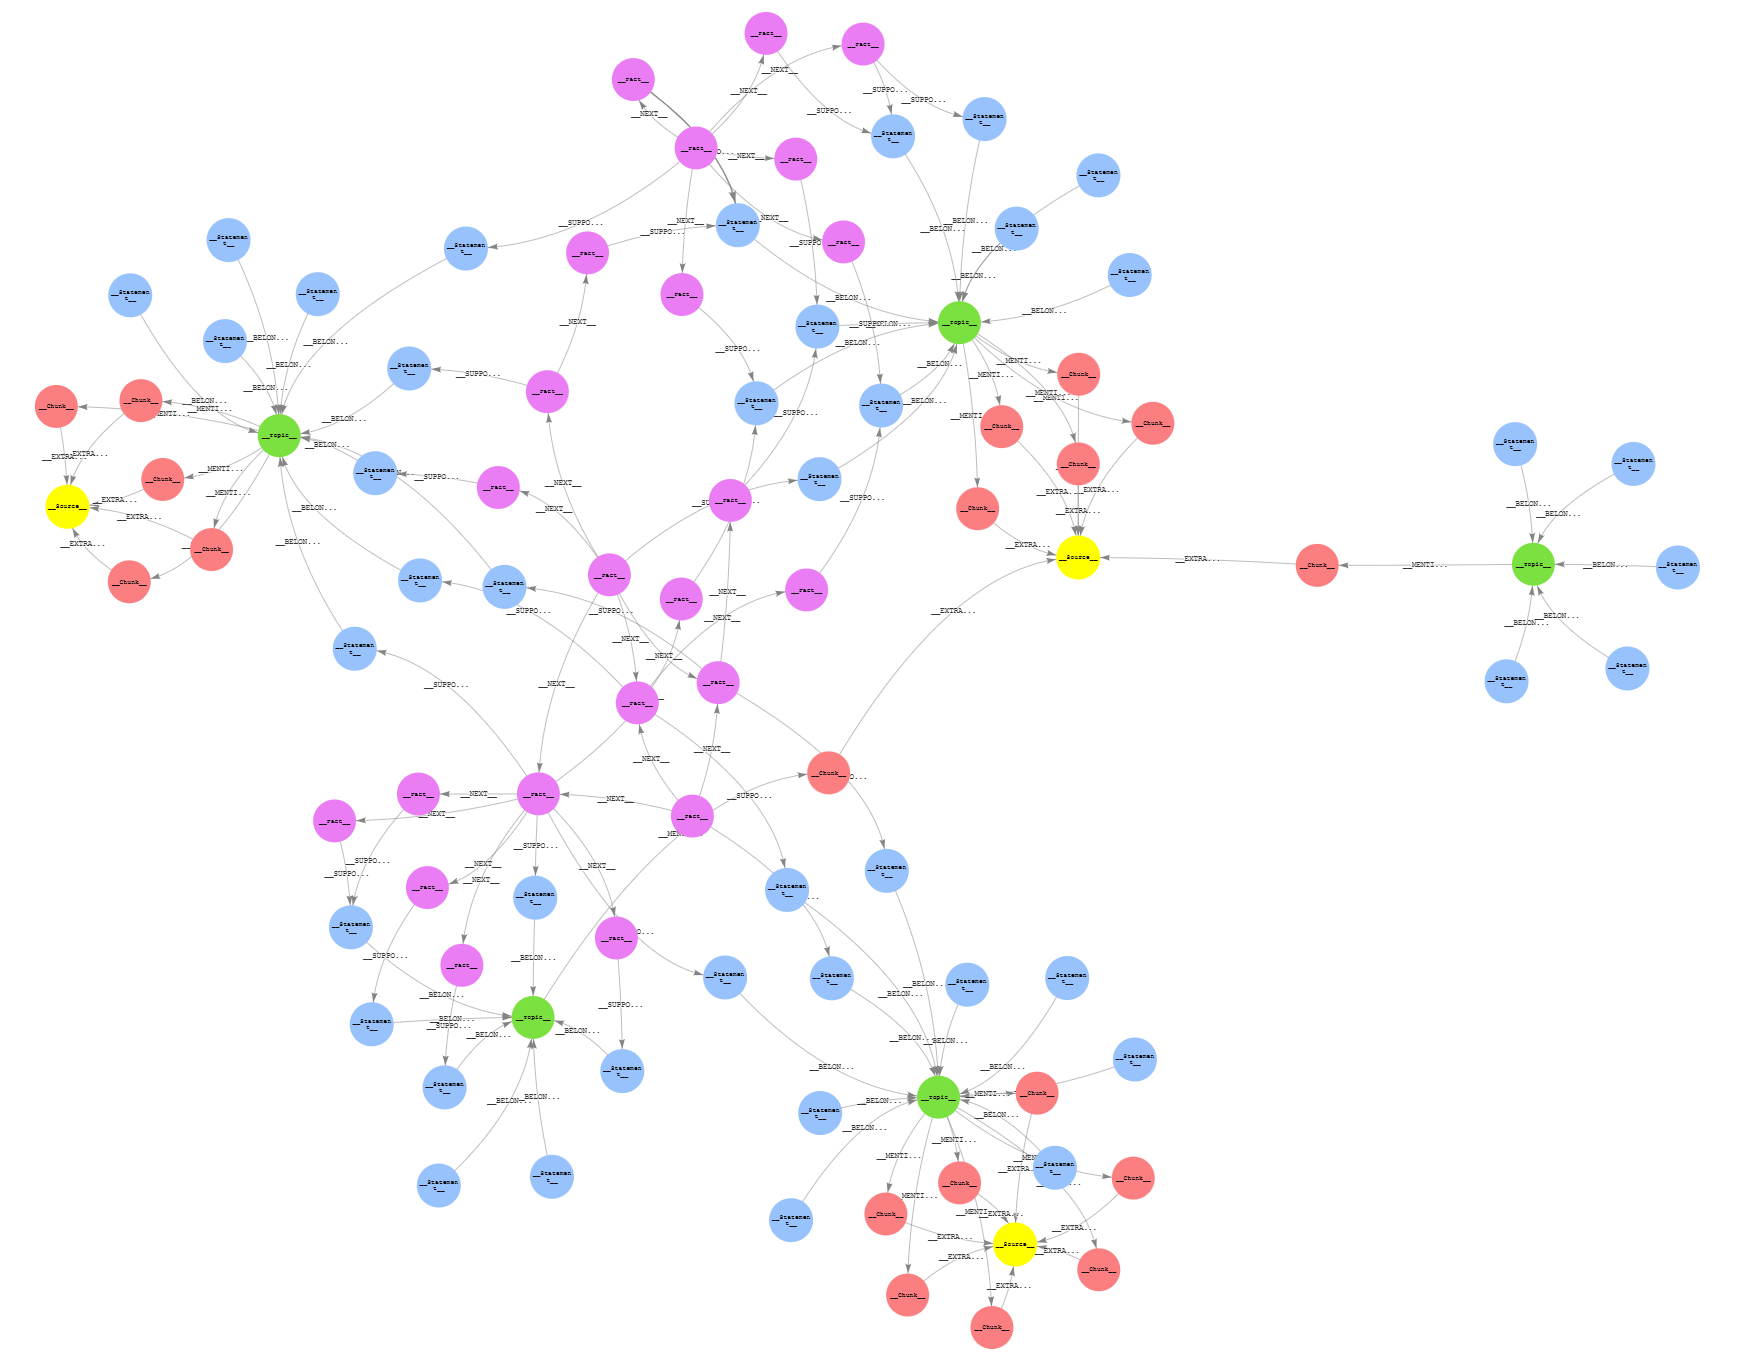